# 1. Choose a dataset (TF datasets or some of your own choice, NOT Keras datasets).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.layers.merge import concatenate

In [ ]:
# tfds.list_builders()

In [ ]:
(test_ds, validate_ds, train_ds), metadata = tfds.load(
'malaria',
split=['train[:15%]', 'train[15%:30%]', 'train[30%:100%]'],
with_info=True,
as_supervised=True)
print(len(test_ds))
print(len(validate_ds))
print(len(train_ds))

4134
4133
19291


# 2. Choose a CNN model. Use a pretrained model from TF Hub or Keras applications (or some other, should you find one). I'd recommend EfficientNet (B0 or B1), but feel free to choose.

In [ ]:
# Create the base model from the pre-trained model EfficientNet B1
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224,224,3), 
    alpha=1.0, 
    minimalistic=True, 
    include_top=False,
    weights='imagenet', 
    classes=2, 
    pooling="avg",
    dropout_rate=0.2, 
    include_preprocessing=False
)

# 3. Implement preprocessing. Your model may work only on images of a certain size, so crop and rescale if needed. Be sure to use the preprocessing operation that comes with the model package - some map pixels to [0,1] and some to [-1,1].


In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = [224, 224]


(train_ds, val_ds, test_ds), metadata = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 224, 224)
  return image,label

In [ ]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_test_ds = (
    test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

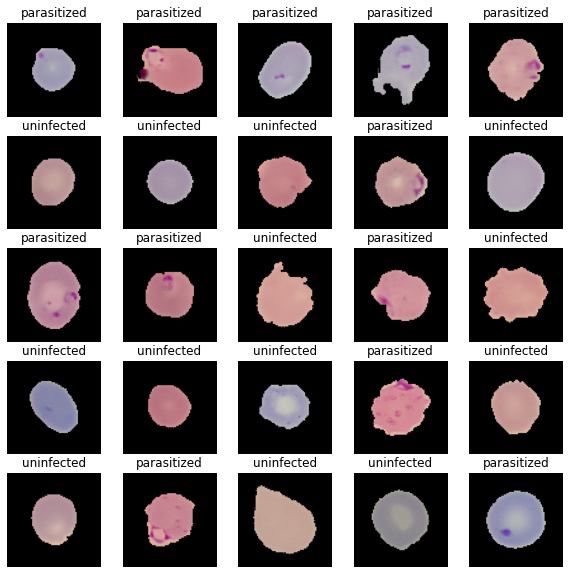

In [ ]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. Build an input pipeline. Preprocessing should be a part of it. Minibatches should fit into GPU memory.

tf.keras.applications.efficientnet.preprocess_input does nothing. not required. so input pipeline and preprocessing are already part of base model.

# 5. Load only the convolutional base of the pre-trained model and build your own decision part on top of that (e.g. two dense layers + softmax). Sometimes a global averaging of the base model output is needed (some architectures do it as their last step, some don't).

In [ ]:
# decision part
def create_decision():
  # create model
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
  x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
  x = Dropout(0.05)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return x, predictions

In [ ]:
# create the model

x, predictions = create_decision()
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# print(model.summary())

In [ ]:
# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# model.compile(optimizer='adam', loss='binary_crossentropy')
# print(model.trainable_variables)

# 6. Implement data augmentation. Use the augmentation layers (build own custom ones if you like) and add them between the input layer and the pre-trained model (use the functional API)

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./255)
])

batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [ ]:
print(train_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

In [ ]:
model.summary()

# 7. Establish a baseline: train and validate your model (with an optimizer of your choice). Plot loss and accuracy curves.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
checkpoint_path = "/content/gdrive/My Drive/models/transfer-net.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

In [ ]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30,
          verbose='auto',
          callbacks=callbacks)

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 2.0996 - binary_accuracy: 0.9189
Epoch 00001: saving model to /content/gdrive/My Drive/models/transfer-net.ckpt
173/173 [==============================] - 151s 819ms/step - loss: 2.0996 - binary_accuracy: 0.9189 - val_loss: 0.3080 - val_binary_accuracy: 0.9398
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.2573 - binary_accuracy: 0.9316
Epoch 00002: saving model to /content/gdrive/My Drive/models/transfer-net.ckpt
173/173 [==============================] - 136s 775ms/step - loss: 0.2573 - binary_accuracy: 0.9316 - val_loss: 0.3038 - val_binary_accuracy: 0.9082
Epoch 3/30
172/173 [============================>.] - ETA: 0s - loss: 0.2399 - binary_accuracy: 0.9343
Epoch 00003: saving model to /content/gdrive/My Drive/models/transfer-net.ckpt
173/173 [==============================] - 134s 764ms/step - loss: 0.2400 - binary_accuracy: 0.9343 - val_loss: 0.2242 - val_binary_accuracy: 0.9394
Epoch 4

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(padded_test_ds)

33/33 [==============================] - 7s 189ms/step - loss: 0.2195 - binary_accuracy: 0.9364


[0.21950174868106842, 0.9363812208175659]

# Plot history

In [ ]:
print(history)
print(history.history)

{'loss': [0.19112040102481842, 0.14484409987926483, 0.13871434330940247, 0.13376012444496155, 0.12918797135353088, 0.12526321411132812, 0.12297723442316055, 0.1196441799402237, 0.11640029400587082, 0.11303027719259262, 0.11020027846097946], 'binary_accuracy': [0.9225026965141296, 0.946140706539154, 0.9488880634307861, 0.9504432082176208, 0.95210200548172, 0.9539163112640381, 0.9551604390144348, 0.956041693687439, 0.9570784568786621, 0.9587372541427612, 0.9586853981018066], 'val_loss': [0.14638684689998627, 0.1390797197818756, 0.13256217539310455, 0.13019819557666779, 0.1285417675971985, 0.12810620665550232, 0.12839004397392273, 0.1278989464044571, 0.1290166676044464, 0.12822845578193665, 0.1319020688533783], 'val_binary_accuracy': [0.9494314193725586, 0.9474957585334778, 0.9499152898788452, 0.9503992199897766, 0.9506411552429199, 0.950883150100708, 0.9501572847366333, 0.9520928859710693, 0.9530607461929321, 0.9537866115570068, 0.9545124769210815]}


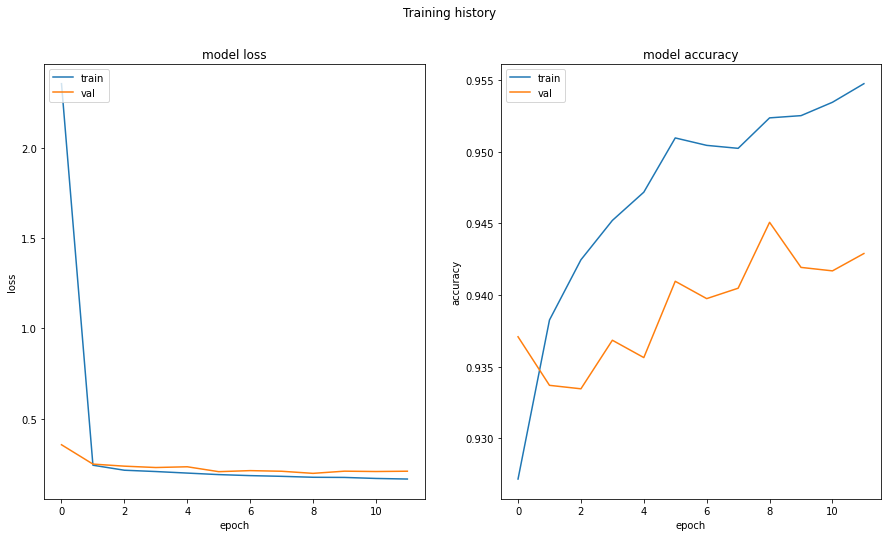

In [ ]:
def plot_training_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
  fig.suptitle('Training history')

  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('model loss')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')

  ax2.plot(history.history['binary_accuracy'])
  ax2.plot(history.history['val_binary_accuracy'])
  ax2.set_title('model accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper left')

  plt.show()

plot_training_metrics(history)

# Fine-tuning the model

Fine-tune the model (trained at 7) by opening a few layers (or layer blocks if it's more natural in the model architecture) at a time. Train with a very small learning rate (might take a few tries to find a good starting value). Repeat opening layers until there's no improvement.

In [ ]:
print(model.summary())

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                                                          

33/33 - 5s - loss: 0.2195 - binary_accuracy: 0.9364 - 5s/epoch - 142ms/step
Restored model, accuracy: 93.64%
Number of layers in the base model:  105
Number of layers in the decision model:  6
Epoch 12/26
151/151 [==============================] - ETA: 0s - loss: 0.1949 - binary_accuracy: 0.9433
Epoch 00012: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned.ckpt
151/151 [==============================] - 52s 324ms/step - loss: 0.1949 - binary_accuracy: 0.9433 - val_loss: 0.2300 - val_binary_accuracy: 0.9284
Epoch 13/26
151/151 [==============================] - ETA: 0s - loss: 0.1740 - binary_accuracy: 0.9499
Epoch 00013: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned.ckpt
151/151 [==============================] - 41s 268ms/step - loss: 0.1740 - binary_accuracy: 0.9499 - val_loss: 0.2641 - val_binary_accuracy: 0.9143
Epoch 14/26
151/151 [==============================] - ETA: 0s - loss: 0.1663 - binary_accuracy: 0.9533
Epoch 00014: saving m

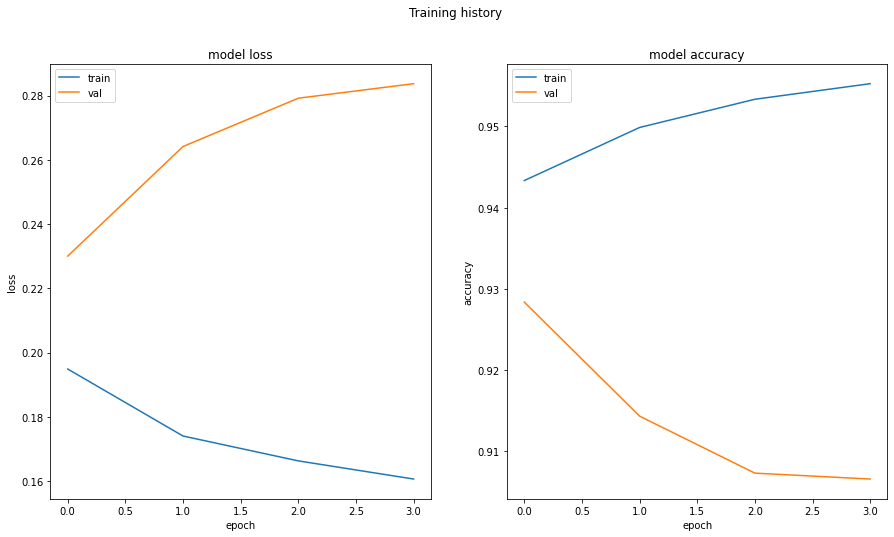

33/33 - 4s - loss: 0.3077 - binary_accuracy: 0.8977 - 4s/epoch - 115ms/step
Fine-tuned model, accuracy: 89.77%


In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - len(base_model.layers))

for layer in base_model.layers:
  layer.trainable = False

# freeze the base model layers
for layer in base_model.layers[0:3]:
  print(layer)
  layer.trainable = True

adam = tf.keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

ft_checkpoint_path = "/content/gdrive/My Drive/models/transfer-net-finetuned.ckpt"
ft_checkpoint_dir = os.path.dirname(ft_checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 15
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(padded_train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=padded_val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

## Fine-tune another layer

33/33 - 4s - loss: 0.3077 - binary_accuracy: 0.8977 - 4s/epoch - 116ms/step
Restored model, accuracy: 89.77%
Epoch 12/19
151/151 [==============================] - ETA: 0s - loss: 0.2126 - binary_accuracy: 0.9330
Epoch 00012: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt
151/151 [==============================] - 36s 217ms/step - loss: 0.2126 - binary_accuracy: 0.9330 - val_loss: 0.2821 - val_binary_accuracy: 0.9095
Epoch 13/19
151/151 [==============================] - ETA: 0s - loss: 0.1741 - binary_accuracy: 0.9517
Epoch 00013: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt
151/151 [==============================] - 30s 198ms/step - loss: 0.1741 - binary_accuracy: 0.9517 - val_loss: 0.2697 - val_binary_accuracy: 0.9119
Epoch 14/19
151/151 [==============================] - ETA: 0s - loss: 0.1616 - binary_accuracy: 0.9566
Epoch 00014: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt
151/151 [=

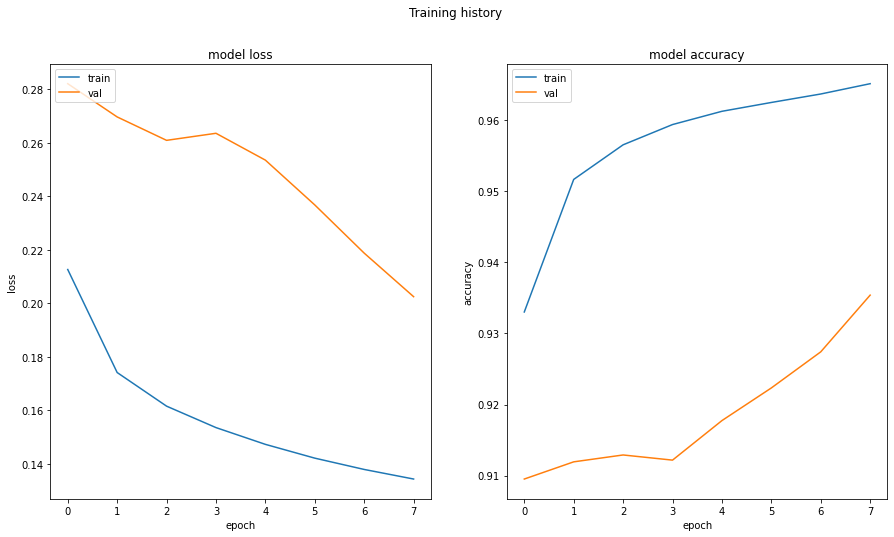

33/33 - 4s - loss: 0.2097 - binary_accuracy: 0.9359 - 4s/epoch - 114ms/step
Fine-tuned model, accuracy: 93.59%


In [ ]:
# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
for layer in base_model.layers:
  layer.trainable = False

# Open up some layers from base model
for layer in base_model.layers[17:21]:
  print(layer)
  layer.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_2 = "/content/gdrive/My Drive/models/transfer-net-finetuned-2.ckpt"
ft_checkpoint_dir_2 = os.path.dirname(ft_checkpoint_path_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs = history_fine.epoch[-1] + fine_tune_epochs

history_fine_2 = model.fit(padded_train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=padded_val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

33/33 - 4s - loss: 0.2097 - binary_accuracy: 0.9359 - 4s/epoch - 115ms/step
Restored model, accuracy: 93.59%
Epoch 19/48
151/151 [==============================] - ETA: 0s - loss: 0.1847 - binary_accuracy: 0.9441
Epoch 00019: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt
151/151 [==============================] - 28s 161ms/step - loss: 0.1847 - binary_accuracy: 0.9441 - val_loss: 0.5288 - val_binary_accuracy: 0.8052
Epoch 20/48
151/151 [==============================] - ETA: 0s - loss: 0.1452 - binary_accuracy: 0.9600
Epoch 00020: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt
151/151 [==============================] - 25s 166ms/step - loss: 0.1452 - binary_accuracy: 0.9600 - val_loss: 0.4669 - val_binary_accuracy: 0.8386
Epoch 21/48
151/151 [==============================] - ETA: 0s - loss: 0.1331 - binary_accuracy: 0.9634
Epoch 00021: saving model to /content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt
151/151 [=

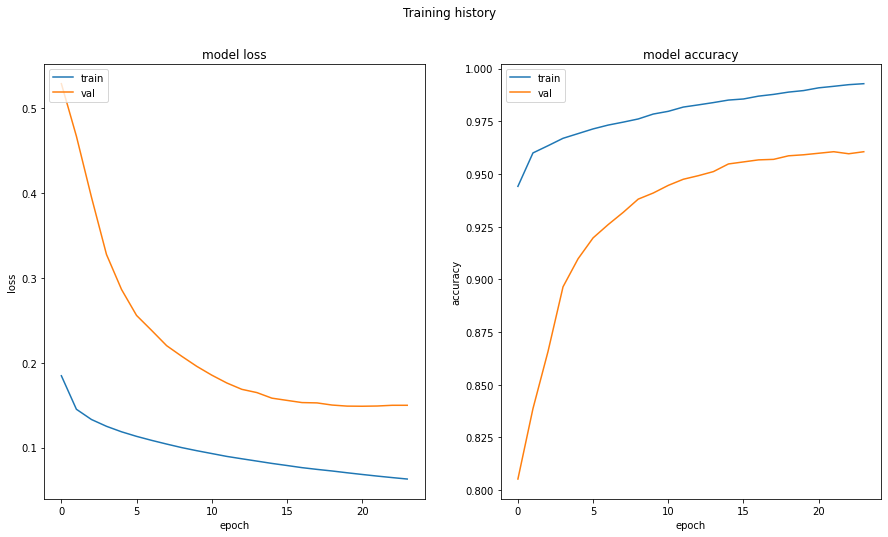

33/33 - 4s - loss: 0.1683 - binary_accuracy: 0.9598 - 4s/epoch - 114ms/step
Fine-tuned model, accuracy: 95.98%


In [ ]:
# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_2)

# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
for layer in base_model.layers:
  layer.trainable = False

# Open up some layers from base model
for layer in base_model.layers[70:80]:
  print(layer)
  layer.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_3 = "/content/gdrive/My Drive/models/transfer-net-finetuned-3.ckpt"
ft_checkpoint_dir_3 = os.path.dirname(ft_checkpoint_path_3)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_3,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs =  history_fine_2.epoch[-1] + history_fine.epoch[-1] + fine_tune_epochs

history_fine_3 = model.fit(padded_train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=padded_val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

# Redo steps 7 and 8 with the following additions to the decision part you built:
### L2 regularization
### Batch Normalization
### Dropout (with small rate) just before softmax
### learning rate scheduler callback


In [ ]:
def scheduler(epoch, lr=0.00005):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_3)

# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
for layer in base_model.layers:
  layer.trainable = False

# Open up some layers from base model
for layer in base_model.layers[70:80]:
  print(layer)
  layer.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=lr_callback, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_4 = "/content/gdrive/My Drive/models/transfer-net-finetuned-4.ckpt"
ft_checkpoint_dir_4 = os.path.dirname(ft_checkpoint_path_4)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_4,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs = history_fine_3.epoch[-1] + history_fine_2.epoch[-1] + history_fine.epoch[-1] + fine_tune_epochs

history_fine_4 = model.fit(padded_train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=padded_val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(padded_test_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

33/33 - 5s - loss: 0.1683 - binary_accuracy: 0.9598 - 5s/epoch - 159ms/step
Restored model, accuracy: 95.98%


NameError: ignored